# P3 - Collaboration and Competition

---

In this notebook, I will describe my solution to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


## Learning Algorithm.

The algorithm I selected is **Deep Deterministic Policy Gradient (DDPG) with Prioritized Experience Replay (PER)**. This is an extension of the solution I provide for P2 (Continuous control).
DQN is described in the paper ["Continuous Control With Deep Reinforcement Learning"](https://arxiv.org/pdf/1509.02971.pdf), while PER is introduced here ["Prioritized Experience Replay"](https://arxiv.org/pdf/1511.05952)

As an Actor-Critic method, DDPG uses two networks. 
* Actor - selects an action to take given a state
* Critic - it "scores" the action selected by the actor, predicting "how good" the action is

To separate calculations and work with more stationary targets, DQN used a second, separate network (**target network**) that lags behind the network we are using to train (**local network**). The weights of the local network are copied onto the target network, but this process only happens every few steps (**hard update**); we could also interpolate the values to try and get closer to the online ones (**soft update**), which is the option we have selected for this project. Either option will effectively "lock" our targets in place during that time.

In DDPG, because we have two distinct networks, we need to keep our "target" and "local" versions of both Actor and Critic to add stability to the training.

To allow some exploration in the Actor, we use an **Ornstein-Uhlenbeck process** for generating noise that will be added to our selected actions. It samples noise from a correlated normal distribution.

The algorithm works as follows:
![title](img/ddpg.png)

### Prioritized Experience Replay

DDPG utilizes a replay buffer to help comply with the [IID assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). By storing our observations in a buffer, and uniformly sampling batches from that buffer, we get experiences that are less correlated. However, this method does not take into account the significance of each of the elements in the buffer. 

With PER, we build our mini-batches considering the value of the experiences in the buffer. Not all of those experiences are equally useful when the agents is trying to train from them, so we select those that maximize this learning value. This is measured by the magnitude of their TD error.

In [Improving DDPG via Prioritized Experience Replay](https://cardwing.github.io/files/RL_course_report.pdf) DDPG was successfully improved by PER. The algorithm (DDPG with rank-based prioritization) looks as follows:

![title](img/per.png)


### Implementation details

To improve readability, the code has been split into different files:

* agent_ddpg.py
* model_ddpg.py
* per_replay_buffer.py
* ounoise.py
* utils.py

These files are commented to help make that code self-explanatory.

In agent_ddpg.py - AgentOverlord::step, we add all of the experiences for all of the agents to the Replay Buffer before we try to learn from it. 

per_replay_buffer.py - in this case, we have adapted the implementation by Jonathan Pearce (https://github.com/Jonathan-Pearce/DDPG_PER/blob/master/PER_buffer.py) so it can work with the rest of the framework we had already constructed in "p2 - continuous control". This implementation makes use of a *Segment Tree*, defined in utils.py


## Architecture and hyperparameters

- Our Actor:
    - Uses a deep neural network with:
    -- An *input layer* with **33 nodes**.
    -- **Three** *hidden layers* with **128 nodes each**.
    -- An *output layer* with **4 nodes**.
    - Applies **batch normalization** on each layer
    - Uses **ReLU** as the activation function of the first two layers, and **Tanh** for the third layer. The latter was selected because the actions are composed of four continuous values in the range [-1..1]
    
    
- Our Critic:
    - Uses a deep neural network with:
    -- An *input layer* with **33 nodes**.
    -- A hidden layer with **256 nodes** + **4 extra inputs** to incorporate the action selected by the actor. 
    -- A second hidden layer with **256 nodes**
    -- A third hidden layer with **128 nodes**
    -- An *output layer* with **1 node**.
    - Only the input layer is batch normalized.
    - We use **ReLU** as the activation function.


- We use an **Adam optimizer**


- We use the following hyperparameters:
    - *Gamma* (discount factor): **0.99**
    - *Tau* (we use a soft update to update the weights of the target network): **1e-3**
    - *Actor Learning Rate*: **1e-3**
    - *Critic Learning Rate*: **1e-3**
    - *Batch size*: **128**
    - *Epsilon*: **0.01**
    - *Alpha exponent* (to what extent the prioritization is used): **0.6** 
    - *Beta exponent* (to control how much importance-sampling weights correct the sample probability): **0.2**
    - *Beta increment per sampling* (to modify beta overtime): **1e-3**


- Lastly, our *replay buffer* size is **1e5**.

## Training

First, let's initialize the Unity environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agent_ddpg import AgentOverlord
import matplotlib.pyplot as plt
import torch as T
import torch.nn.functional as F
from collections import deque

# Initialize the environment - please note we're using v2 of the problem (multiple agents)
env = UnityEnvironment( file_name='Tennis_Windows_x86_64/Tennis.exe' )

# Get brain - this will be used to control the unity environment
brain_name = env.brain_names[ 0 ]
brain = env.brains[ brain_name ]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



###  Agent initialization

From the description of the problem, we know that:

> In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.
The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

With this information, let's initialize our agents and get prepared to solve the problem (in this implementation, we are actually adding an "agent overlord" that will keep track of all of our agents).

In [2]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

# number of agents
num_agents = states.shape[ 0 ]
print('Number of agents:', num_agents)

# hyperparameters
actor_hidden = [128, 128, 128]
actor_activation = [F.relu, F.relu, F.relu, T.tanh]

critic_hidden = [256, 256, 128]

gamma = 0.99
tau = 1e-3
actor_learning_rate = 1e-3
critic_learning_rate = 1e-3
buffer_size = int(1e5)
batch_size= 128
seed = 19
epsilon = 0.01
alpha = 0.6
beta = 0.2
beta_increment_per_sampling = 1e-3

# Initialize device
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

# initialize overlord
agent_overlord = AgentOverlord( device, 
                                state_size, action_size, num_agents, 
                                actor_hidden, actor_activation,
                                critic_hidden, 
                                gamma, tau, actor_learning_rate, critic_learning_rate, 
                                buffer_size, batch_size, 
                                seed, 
                                epsilon, alpha, beta, beta_increment_per_sampling )


Size of each action: 2
Number of agents: 2


### Solving the problem

We are now ready to start solving the problem.

From the problem description:

> The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically, after each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 score, which yields a single score for each episode.
The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

We are setting a maximum number of episodes of *5000*.

Episode 100	Average Score: 0.00470
Episode 200	Average Score: 0.02060
Episode 300	Average Score: 0.05330
Episode 400	Average Score: 0.06990
Episode 500	Average Score: 0.08580
Episode 600	Average Score: 0.09010
Episode 700	Average Score: 0.09320
Episode 800	Average Score: 0.25300
Episode 900	Average Score: 0.15880
Episode 1000	Average Score: 0.31580
Episode 1026	Average Score: 0.50960Sucess in 1026 episodes!
Mean score was: 0.50960, above the criterium 0.50000.


<function matplotlib.pyplot.show(close=None, block=None)>

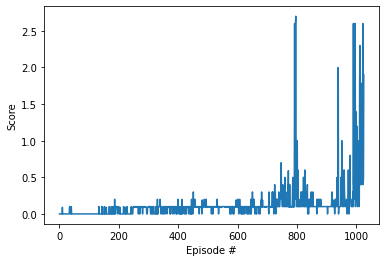

In [4]:
MAX_EPISODES = 5000
MIN_SUCCESS_MEAN_SCORE = 0.5

EPISODE_RANGE_COUNT = 100

scores_deque = deque(maxlen=EPISODE_RANGE_COUNT)
scores = []

success = False
for episode in range(1,MAX_EPISODES):
    
    # let's restart the environment and get the initial states of the agents
    env_info = env.reset( train_mode=True )[ brain_name ]    
    states = env_info.vector_observations
    score = np.zeros(num_agents)
    agent_overlord.reset()

    while True:

        # choose the actions we should take
        actions = agent_overlord.act( states )

        # apply them
        env_info = env.step( actions )[ brain_name ]

        next_states = env_info.vector_observations

        rewards = env_info.rewards
        dones = env_info.local_done

        # update the overlord
        agent_overlord.step( states, actions, rewards, next_states, dones )

        # update states for next iteration
        states = next_states

        score += env_info.rewards

        if np.any( dones ):
            # episode is done
            break

    # Gets max score obtained by either agent
    max_score = np.max(score)

    scores_deque.append(max_score)           
    scores.append(max_score)
    
    # Calculate the mean score so far 
    mean_score_so_far = np.mean(scores_deque)
        
    print('\rEpisode {}\tAverage Score: {:.5f}'.format(episode, mean_score_so_far), end="")
    if episode % EPISODE_RANGE_COUNT == 0:
        print('\rEpisode {}\tAverage Score: {:.5f}'.format(episode, mean_score_so_far))

    # If our deque is full, this means we have enough episodes to potentially end the experiment.
    # In that case, if the mean of the scores in the last episodes is over the success criterium
    if len(scores_deque) == EPISODE_RANGE_COUNT and mean_score_so_far > MIN_SUCCESS_MEAN_SCORE:
        # End experiment
        success = True
        break
    
if success:
    print("Sucess in {:d} episodes!".format(episode))
    print( "Mean score was: {:.5f}, above the criterium {:.5f}.".format(mean_score_so_far, MIN_SUCCESS_MEAN_SCORE))
    
    # Save the trained model
    agent_overlord.save()
else:
    print("We did not reach the desired score {:.5f}/{:.5f}".format(mean_score_so_far, MIN_SUCCESS_MEAN_SCORE))

# Plot a figure showing the mean score per episode
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show

### 4. Test

If our experiment succeeded in the previous step, that means we now have a trained model. Let's  the environment once more, and look at how the agents perform in real-time for one episode. 

In [7]:
# Now, load the saved model
# - Actually, we don't need to do this, as the overlord is still loaded at this point
# - But this is what we would have to do if we need to load it from file
# agent_overlord.reset()
# agent_overlord.load()

env_info = env.reset( train_mode=False )[ brain_name ]    
states = env_info.vector_observations
    
episode_num = 5
for i in range(episode_num):
    while True:
        # choose the actions we should take
        actions = agent_overlord.act( states )

        # apply them
        env_info = env.step( actions )[ brain_name ]

        dones = env_info.local_done
        if np.any( dones ):
            # episode is done
            break

        # update states for next iteration
        states = env_info.vector_observations

In [8]:
# And, finally, close the environment
env.close()

This is a video recording of the test results running in Unity.

In [9]:
from IPython.display import IFrame

IFrame(src='https://www.youtube.com/embed/cJtI-rwTXxI', width='560', height='315')

## Ideas for future work

The first thing we could try to improve our solution is to study the effects of the different hyperparameters on the results we obtain. Could we use more hidden layers? Larger or shorter ones? Are our tau, gamma, etc. correct, or can we choose something better? 

I work in AAA videogames. The solution chosen uses a Replay Buffer, which can potentially consume a lot of memory (depending on the problem). Multithreading a solution can sometimes be easier than optimizing its memory usage. This makes algorithms such as **Advantage Actor-Critic (A3C)** interesting, as they do not rely on "memory" to fight correlation, but instead use the observations of multiple independent agents.

I would also like to try [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/pdf/1706.02275), as it looks like it might outperform my solution.

It would be interesting to compare the performance and results of these two different approaches, as well of their memory requirements, to get more data that can inform whether this type of RL is feasible for a modern AAA videogame.